In [85]:
import pickle

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


def p_read(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

In [86]:
simswap_embeddings = p_read("simswap_embeddings.pickle")
codec_tex_embeddings = p_read("../ava-256/tex_embeddings.pickle")
codec_geo_embeddings = p_read("../ava-256/geo_embeddings.pickle")
codec_pca_embeddings = p_read("../ava-256/pca_embeddings.pickle")
speaker_embeddings = p_read("../DDDM-VC/speaker_embeddings.pickle")

In [87]:
def print_stats(embedding, embedding_label):
    flat_embedding = embedding.reshape(embedding.shape[0], -1)
    print(f"Statistics for {embedding_label}:")
    print(f"\tembedding shape: {flat_embedding[0].shape}")
    print(f"\tmean: {np.mean(flat_embedding)}")
    print(f"\tstd: {np.std(flat_embedding)}")
    print(f"\taverage magnitude: {np.mean(np.linalg.norm(flat_embedding, axis=1))}")
    print(f"\tstd of magnitudes: {np.std(np.linalg.norm(flat_embedding, axis=1))}")

In [88]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    magnitude_a = np.linalg.norm(a)
    magnitude_b = np.linalg.norm(b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0  # Handle zero vector case

    return dot_product / (magnitude_a * magnitude_b)


def visualize_hists(embedding, embedding_label, min_comparisons=2000):
    embedding = embedding.reshape(embedding.shape[0], -1)
    random_vectors = np.random.uniform(
        low=-1, high=1, size=(embedding.shape[0], embedding.shape[1])
    )
    magnitudes = np.linalg.norm(embedding, axis=1)
    angles, angles_rand = [], []
    cardinal_direction = np.zeros_like(embedding[0])
    cardinal_direction[0] = 1

    all_pairs = []
    for i in range(min(embedding.shape[0], min_comparisons)):
        for j in range(embedding.shape[0]):
            if i != j:
                all_pairs.append((i, j))

    np.random.shuffle(all_pairs)

    for i in range(min(len(all_pairs), min_comparisons)):
        angles.append(
            180
            / np.pi
            * np.arccos(
                cosine_similarity(
                    embedding[all_pairs[i][0]], embedding[all_pairs[i][1]]
                )
            )
        )
        angles_rand.append(
            180
            / np.pi
            * np.arccos(
                cosine_similarity(
                    random_vectors[all_pairs[i][0]], random_vectors[all_pairs[i][1]]
                )
            )
        )

    angles = np.asarray(angles)
    angles_rand = np.asarray(angles_rand)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].hist(magnitudes, range=(0, magnitudes.max()))
    ax[0].set_title("Magnitudes of embeddings")

    ax[1].hist(
        angles, alpha=0.5, color="r", label="between samples", bins=90, range=(0, 180)
    )
    ax[1].hist(
        angles_rand,
        alpha=0.5,
        color="grey",
        label="between pairs of random vectors",
        bins=90,
        range=(0, 180),
    )

    # Add the vertical line
    ax[1].axvline(x=90, color="b", alpha=0.5, linestyle="--")

    # # Add text annotation
    # text_x = x_value
    # text_y = max(y)
    # plt.text(text_x, text_y, f'x = {x_value}', ha='center', va='bottom')

    ax[1].set_title(f"θ between {min(len(all_pairs), min_comparisons)} embedding pairs")
    ax[1].set_xticks([0, 45, 90, 135, 180])
    ax[1].legend()
    fig.suptitle(f"{embedding_label} embeddings in R^{embedding.shape[1]}")
    plt.tight_layout()
    plt.show()

In [89]:
def visualize_tsne(embedding, embedding_label, num_random_vectors=256):
    embedding = embedding.reshape(embedding.shape[0], -1)
    if embedding.shape[0] > num_random_vectors:
        np.random.shuffle(embedding)
        embedding = embedding[0:num_random_vectors, :]

    random_vectors = np.random.normal(
        loc=0, scale=1, size=(num_random_vectors, embedding.shape[1])
    )
    # random_vectors = random_vectors / np.linalg.norm(random_vectors, axis=1, keepdims=True)

    # Combine input vectors and random vectors
    all_vectors = np.concatenate((embedding, random_vectors))

    # Standardize the data
    scaler = StandardScaler()
    standardized_vectors = scaler.fit_transform(all_vectors)

    # Apply TSNE to reduce dimensionality to 3D
    tsne = TSNE(n_components=2, random_state=42)
    tsne_reduced_vectors = tsne.fit_transform(all_vectors)
    # tsne_reduced_vectors = tsne_reduced_vectors / np.linalg.norm(tsne_reduced_vectors, axis=1, keepdims=True)

    # # Apply PCA to reduce dimensionality to 3D
    # pca = PCA(n_components=3, random_state=42)
    # pca_reduced_vectors = pca.fit_transform(standardized_vectors)
    # pca_reduced_vectors = pca_reduced_vectors / np.linalg.norm(
    #     pca_reduced_vectors, axis=1, keepdims=True
    # )

    # Separate input vectors and random vectors
    num_input_vectors = embedding.shape[0]
    tsne_input_reduced_vectors = tsne_reduced_vectors[:num_input_vectors]
    tsne_random_reduced_vectors = tsne_reduced_vectors[num_input_vectors:]
    # pca_input_reduced_vectors = pca_reduced_vectors[:num_input_vectors]
    # pca_random_reduced_vectors = pca_reduced_vectors[num_input_vectors:]

    # Create figure with two subplots
    fig = plt.figure(figsize=(4, 4))

    # Create TSNE subplot
    ax1 = fig.add_subplot(
        111,
    )  # projection="3d")
    ax1.scatter(
        tsne_input_reduced_vectors[:, 0],
        tsne_input_reduced_vectors[:, 1],
        # tsne_input_reduced_vectors[:, 2],
        c="r",
        alpha=0.5,
    )
    ax1.scatter(
        tsne_random_reduced_vectors[:, 0],
        tsne_random_reduced_vectors[:, 1],
        # tsne_random_reduced_vectors[:, 2],
        c="grey",
        alpha=0.5,
    )
    ax1.set_title("TSNE Visualization")

    # # Create PCA subplot
    # ax2 = fig.add_subplot(122, projection="3d")
    # ax2.scatter(
    #     pca_input_reduced_vectors[:, 0],
    #     pca_input_reduced_vectors[:, 1],
    #     pca_input_reduced_vectors[:, 2],
    #     c="r",
    # )
    # ax2.scatter(
    #     pca_random_reduced_vectors[:, 0],
    #     pca_random_reduced_vectors[:, 1],
    #     pca_random_reduced_vectors[:, 2],
    #     c="grey",
    #     alpha=0.5,
    # )
    # ax2.set_title("PCA (with data standardization)")

    red_patch = mpatches.Patch(color="red", label="Identity embeddings")
    blue_patch = mpatches.Patch(color="grey", label="Normal distribution (μ=0,σ=1)")

    plt.legend(handles=[red_patch, blue_patch])

    fig.suptitle(f"Visualization in R^2: {embedding_label}")
    plt.tight_layout()
    plt.show()

Statistics for Arcface:
	embedding shape: (512,)
	mean: 0.0002624625922180712
	std: 0.04419337585568428
	average magnitude: 1.0
	std of magnitudes: 3.530369241389053e-08


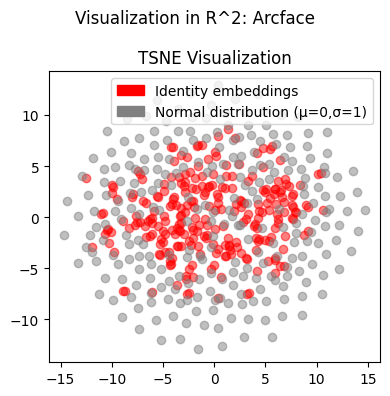

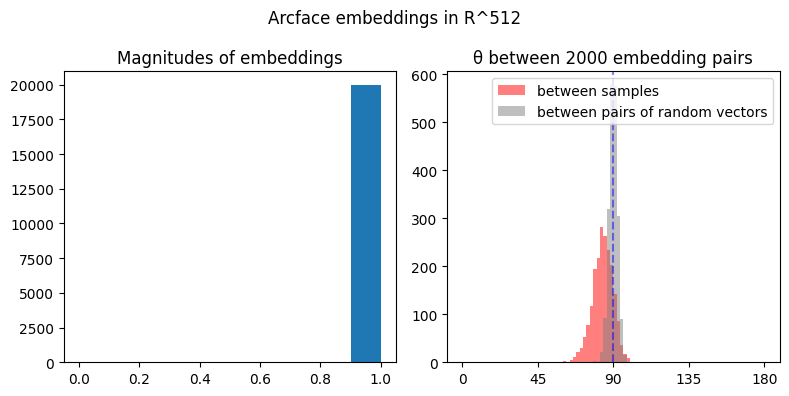

Statistics for Codec U-net (tex):
	embedding shape: (256,)
	mean: 0.007215634919703007
	std: 1.9799131155014038
	average magnitude: 31.401817321777344
	std of magnitudes: 4.180145263671875


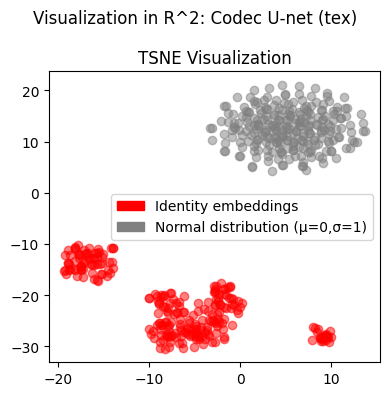

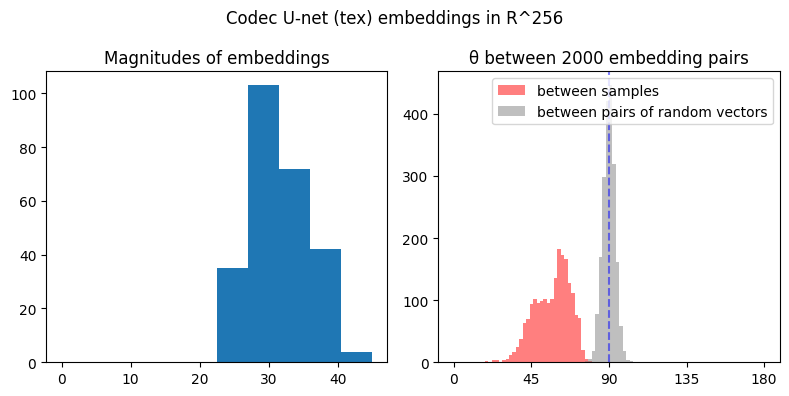

Statistics for Codec U-net (geo):
	embedding shape: (256,)
	mean: 0.2560533583164215
	std: 5.150867938995361
	average magnitude: 81.74247741699219
	std of magnitudes: 11.2694091796875


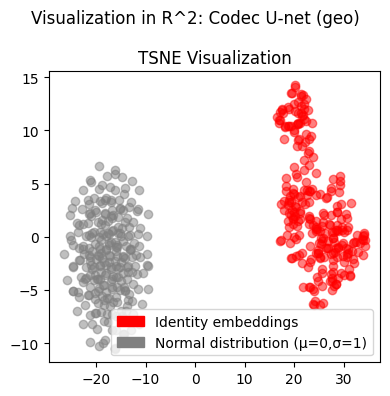

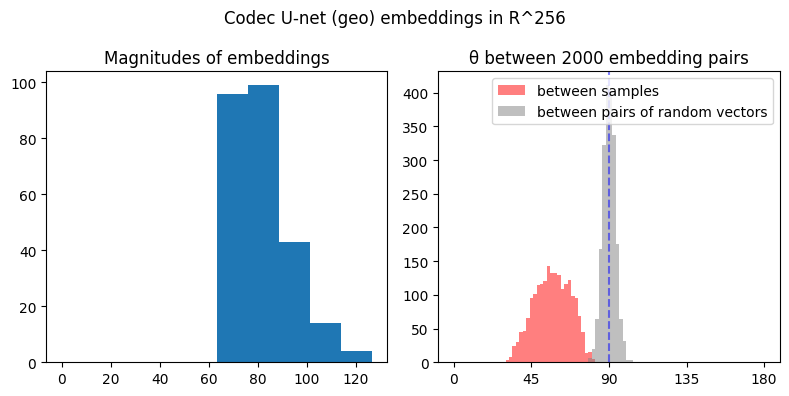

Statistics for Codec with PCA reduction:
	embedding shape: (16,)
	mean: -3.969762474298477e-08
	std: 3.2181315422058105
	average magnitude: 12.399924278259277
	std of magnitudes: 3.4559826850891113


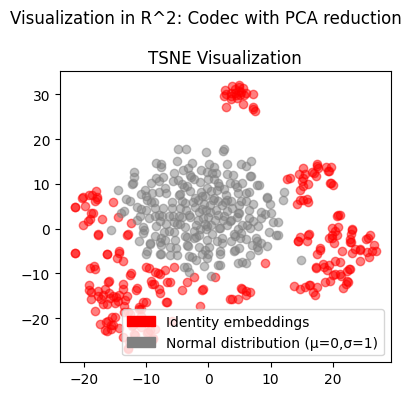

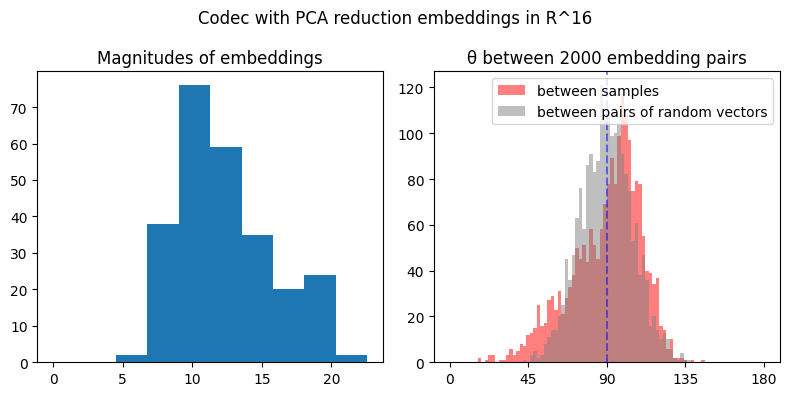

Statistics for Codec with PCA & normalization:
	embedding shape: (16,)
	mean: 0.004555216059088707
	std: 0.24995850026607513
	average magnitude: 1.0
	std of magnitudes: 6.188916756855178e-08


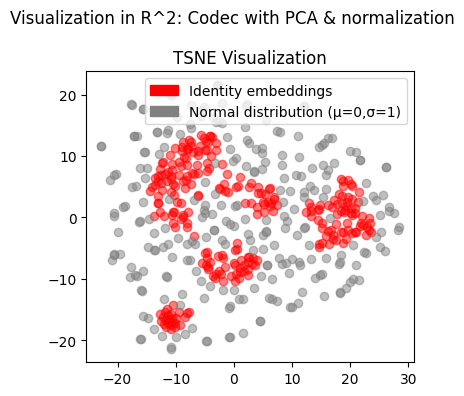

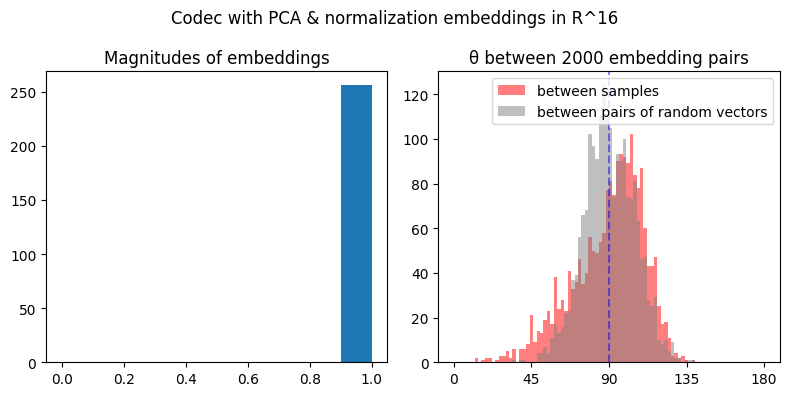

Statistics for DDDM-VC:
	embedding shape: (256,)
	mean: 0.004262416157871485
	std: 0.6782104969024658
	average magnitude: 10.780385971069336
	std of magnitudes: 1.2410094738006592


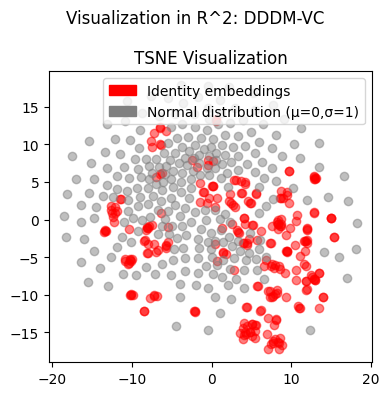

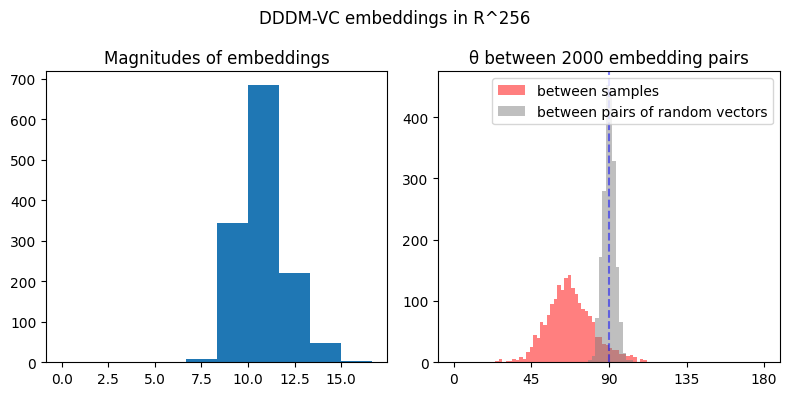

In [91]:
for embedding, label in zip(
    [
        simswap_embeddings,
        codec_tex_embeddings,
        codec_geo_embeddings,
        codec_pca_embeddings,
        codec_pca_embeddings
        / np.linalg.norm(codec_pca_embeddings, axis=1, keepdims=True),
        speaker_embeddings,
    ],
    [
        "Arcface",
        "Codec U-net (tex)",
        "Codec U-net (geo)",
        "Codec with PCA reduction",
        "Codec with PCA & normalization",
        "DDDM-VC",
    ],
):
    print_stats(embedding, label)
    visualize_tsne(embedding, label)
    visualize_hists(embedding, label)